<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Chart_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> SETUP </H1>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#7 classes: Area chart, Bar chart, Line Chart, pie chart, scatter plot. 100 images per class. 80/20 train/val split
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'


<H1>BASELINE MODEL</H1>

In [4]:
#List of all basic tunable parameters of the model - to be updated
img_width, img_height = 224, 224
nb_train_samples = 560
nb_validation_samples = 140
epochs = 100
batch_size = 16

In [5]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [6]:
#Performing augmentation on image scaling, zoom and fliiping the images horizontally so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [7]:
sample_training_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

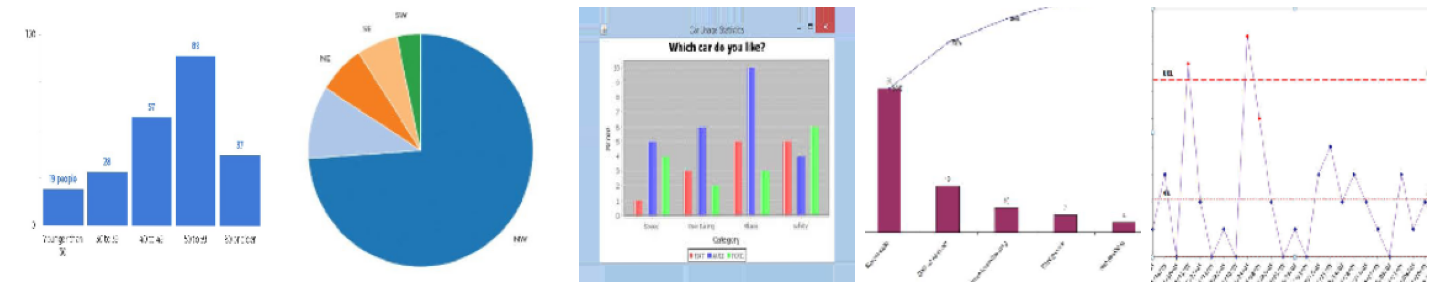

In [8]:
plotImages(sample_training_images[:5])

TRANSFER LEARNING

MOBILENETV2 - transfer learning

In [19]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [20]:
base_model.trainable=False

In [21]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(7,activation='softmax')(x) #final layer with softmax activation
tl_model = keras.Model(inputs= base_model.input, outputs=preds)

In [22]:
tl_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

tl_history = tl_model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=100, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Epoch 1/100
35/35 [==============================] - 11s 314ms/step - loss: 1.4641 - accuracy: 0.6786 - val_loss: 0.7104 - val_accuracy: 0.7344
Epoch 2/100
35/35 [==============================] - 10s 291ms/step - loss: 0.2995 - accuracy: 0.8982 - val_loss: 0.7838 - val_accuracy: 0.8516
Epoch 3/100
35/35 [==============================] - 10s 290ms/step - loss: 0.2857 - accuracy: 0.9250 - val_loss: 0.3801 - val_accuracy: 0.8516
Epoch 4/100
35/35 [==============================] - 10s 293ms/step - loss: 0.2367 - accuracy: 0.9571 - val_loss: 0.4069 - val_accuracy: 0.8906
Epoch 5/100
35/35 [==============================] - 10s 292ms/step - loss: 0.0822 - accuracy: 0.9857 - val_loss: 0.2809 - val_accuracy: 0.9531
Epoch 6/100
35/35 [==============================] - 10s 291ms/step - loss: 0.2129 - accuracy: 0.9768 - val_loss: 0.5830 - val_accuracy: 0.8984
Epoch 7/100
35/35 [==============================] - 10s 299ms/step - loss: 0.1704 - accuracy: 0.9714 - val_loss: 0.3345 - val_accuracy:

VGG16 KERAS - from scratch

In [49]:
vgg_model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same',activation='relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
   
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
   
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
   
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(7, activation='softmax')
])

vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

In [50]:
 vgg_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

vgg_history = vgg_model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=100, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 15s 420ms/step - loss: 57578.9023 - accuracy: 0.1464 - val_loss: 1.9456 - val_accuracy: 0.1406
Epoch 2/100
35/35 [==============================] - 15s 418ms/step - loss: 1.9484 - accuracy: 0.1286 - val_loss: 1.9461 - val_accuracy: 0.1328
Epoch 3/100
35/35 [==============================] - 15s 417ms/step - loss: 1.9472 - accuracy: 0.1161 - val_loss: 1.9459 - val_accuracy: 0.1406
Epoch 4/100
35/35 [==============================] - 15s 418ms/step - loss: 1.9472 - accuracy: 0.1143 - val_loss: 1.9459 - val_accuracy: 0.1406
Epoch 5/100
35/35 [==============================] - 15s 414ms/step - loss: 1.9466 - accuracy: 0.1321 - val_loss: 1.9459 - val_accuracy: 0.1328
Epoch 6/100
35/35 [==============================] - 14s 413ms/step - loss: 1.9468 - accuracy: 0.1161 - val_loss: 1.9462 - val_accuracy: 0.1172
Epoch 7/100
35/35 [==============================] - 15s 414ms/step - loss: 1.9465 - accuracy: 0.1286 - val_loss: 1.9461 - val_accur

KeyboardInterrupt: ignored

VGG KERAS - transfer learning

In [40]:
base_model_2 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [42]:
x2=base_model_2.output
x2=GlobalAveragePooling2D()(x2)
x2=Dense(1024,activation='relu')(x2) #we add dense layers so that the model can learn more complex functions and classify for better results.
x2=Dense(1024,activation='relu')(x2) #dense layer 2
x2=Dense(512,activation='relu')(x2) #dense layer 3
preds2=Dense(7,activation='softmax')(x2) #final layer with softmax activation
tl_model_2 = keras.Model(inputs= base_model_2.input, outputs=preds2)

In [43]:
tl_model_2.compile(optimizer='rmsprop',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

tl_history_2 = tl_model_2.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=100, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 12s 339ms/step - loss: 1.5306 - accuracy: 0.4286 - val_loss: 0.6388 - val_accuracy: 0.7891
Epoch 2/100
35/35 [==============================] - 12s 333ms/step - loss: 0.6460 - accuracy: 0.7732 - val_loss: 0.3491 - val_accuracy: 0.9219
Epoch 3/100
35/35 [==============================] - 12s 335ms/step - loss: 0.4374 - accuracy: 0.8536 - val_loss: 0.3041 - val_accuracy: 0.9062
Epoch 4/100
35/35 [==============================] - 12s 333ms/step - loss: 0.2818 - accuracy: 0.9161 - val_loss: 1.3447 - val_accuracy: 0.7812
Epoch 5/100
35/35 [==============================] - 12s 334ms/step - loss: 0.2488 - accuracy: 0.9232 - val_loss: 0.3346 - val_accuracy: 0.9141
Epoch 6/100
35/35 [==============================] - 12s 334ms/step - loss: 0.2517 - accuracy: 0.9232 - val_loss: 0.5090 - val_accuracy: 0.8672
Epoch 7/100
35/35 [==============================] - 12s 342ms/step - loss: 0.2018 - accuracy: 0.9393 - val_loss: 0.3962 - val_accuracy: